In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [1]:

# Configuración global
BASE_PATH = "D:/Python U/tomate"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 11
EPOCHS = 4


In [3]:

# Generadores de datos
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'valid'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 38422 images belonging to 11 classes.
Found 19206 images belonging to 11 classes.
Found 6422 images belonging to 11 classes.


In [4]:

# Arquitectura 1: CNN Simple con capas secuenciales
def create_model_1():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Arquitectura 2: CNN con concatenación de capas
def create_model_2():
    input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Primera rama
    x1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    
    # Segunda rama
    x2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    
    # Concatenación
    concat = layers.Concatenate()([x1, x2])
    
    # Capas adicionales
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(concat)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs=input_layer, outputs=output)

# Arquitectura 3: CNN con convolución separable
def create_model_3():
    model = models.Sequential([
        layers.SeparableConv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.SeparableConv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.SeparableConv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# Arquitectura 4: CNN con convoluciones aisladas (corregida)
def create_model_4():
    input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    
    # Ramas paralelas con padding='same' para mantener las dimensiones
    branch1 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    branch1 = layers.MaxPooling2D((2, 2))(branch1)
    
    branch2 = layers.Conv2D(32, (5, 5), padding='same', activation='relu')(input_layer)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    
    branch3 = layers.Conv2D(32, (7, 7), padding='same', activation='relu')(input_layer)
    branch3 = layers.MaxPooling2D((2, 2))(branch3)
    
    # Concatenación (ahora todos los tensores tienen el mismo tamaño)
    concat = layers.Concatenate()([branch1, branch2, branch3])
    
    # Capas finales
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(concat)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    return Model(inputs=input_layer, outputs=output)

def train_and_evaluate_model(model, model_name):
    # Compilación
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_model_{model_name}.h5', monitor='val_accuracy', save_best_only=True)
    ]
    
    # Entrenamiento
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    
    # Evaluación
    test_results = model.evaluate(test_generator)
    
    return history, test_results


In [5]:

def plot_training_history(histories, model_names):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} (train)')
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [6]:

# Crear y entrenar los modelos
models = [
    (create_model_1(), "Simple CNN"),
    (create_model_2(), "Concatenated CNN"),
    (create_model_3(), "Separable CNN"),
    (create_model_4(), "Isolated CNN")
]

results = []
histories = []
test_results = []

for model, name in models:
    print(f"\nTraining {name}...")
    history, test_result = train_and_evaluate_model(model, name)
    histories.append(history)
    test_results.append(test_result)
    results.append({
        'Model': name,
        'Test Loss': test_result[0],
        'Test Accuracy': test_result[1]
    })



Training Simple CNN...
Epoch 1/4
1201/1201 [==============================] - 1488s 1s/step - loss: 1.2666 - accuracy: 0.5511 - val_loss: 0.7652 - val_accuracy: 0.7333
Epoch 2/4
1201/1201 [==============================] - 1432s 1s/step - loss: 0.7418 - accuracy: 0.7391 - val_loss: 0.6139 - val_accuracy: 0.7842
Epoch 3/4
1201/1201 [==============================] - 1431s 1s/step - loss: 0.5584 - accuracy: 0.8026 - val_loss: 0.5885 - val_accuracy: 0.7961
Epoch 4/4
201/201 [==============================] - 79s 393ms/step - loss: 0.5466 - accuracy: 0.8209

Training Concatenated CNN...
Epoch 1/4
1201/1201 [==============================] - 4121s 3s/step - loss: 1.5208 - accuracy: 0.4999 - val_loss: 0.9639 - val_accuracy: 0.6646
Epoch 2/4
1201/1201 [==============================] - 4239s 4s/step - loss: 0.8285 - accuracy: 0.7101 - val_loss: 0.8138 - val_accuracy: 0.7142
Epoch 3/4
1201/1201 [==============================] - 4222s 4s/step - loss: 0.5479 - accuracy: 0.8087 - val_loss: 0.76

In [7]:

# Mostrar resultados
results_df = pd.DataFrame(results)
print("\nComparación de Resultados:")
print(results_df)



Comparación de Resultados:
              Model  Test Loss  Test Accuracy
0        Simple CNN   0.546640       0.820928
1  Concatenated CNN   0.738655       0.767985
2     Separable CNN   0.617343       0.784335
3      Isolated CNN   0.772483       0.760822


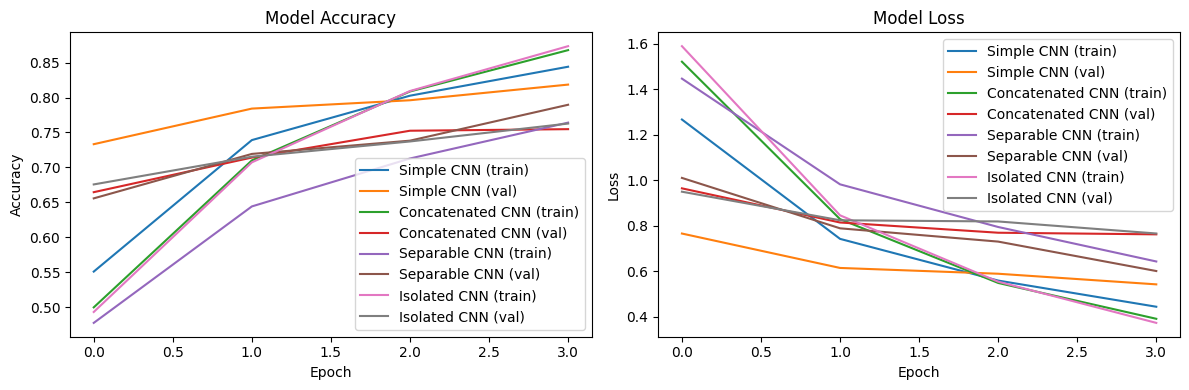

In [8]:

# Visualizar historiales de entrenamiento
plot_training_history(histories, [model[1] for model in models])


In [9]:

# Guardar resultados en un archivo CSV
results_df.to_csv('model_comparison_results.csv', index=False)